In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [51]:
! brew install libomp

Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 3 taps (brewsci/bio, homebrew/core and homebrew/cask).
==> New Formulae
actions-batch              gptscript                  phodav
appwrite                   inlyne                     pkl
bluez                      kubeshark                  prjtrellis
bpftop                     liborigin                  scala@3.3
c4core                     libsql                     sigi
cargo-fuzz                 lsusb-laniksj              srgn
cmake-language-server      mdsh                       taskopen
edbrowse                   mmdbinspect                typstfmt
edgevpn                    mubeng                     vrc-get
erlang_ls                  nmail                      wstunnel
gimmecert                  npm-check-updates
gnmic                      pass-import
==> New Casks
apidog-europe              jan                        wifiman
arturia-software-center    motion                     yes24-ebook
deelay     

In [52]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

  Using cached lightgbm-4.3.0.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightgbm: filename=lightgbm-4.3.0-py3-none-macosx_14_0_arm64.whl size=1417997 sha256=02a526d6aeb994edb6680dd4c13f694cf4cd0fcf7533dc55d794db04e2cb2bc6
  Stored in directory: /Users/mariababaeva/Library/Caches/pip/wheels/6b/92/ab/b7b5df76502b64443c1a830e5f7ec3cb66741313ddebb682aa
Successfully built lightgbm


In [59]:
from catboost import 

NameError: name 'catboost' is not defined

In [40]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

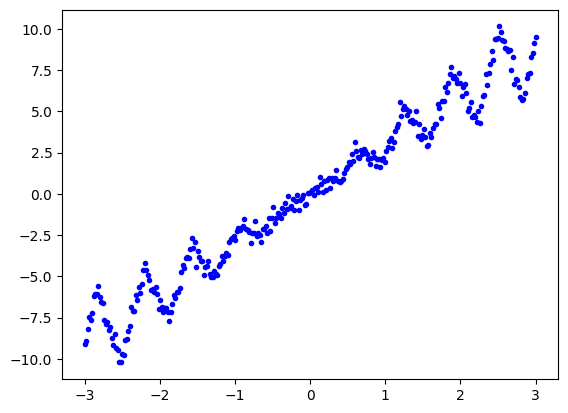

In [56]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [59]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")
    plt.plot(X, y, "r.")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
clf1 = DecisionTreeRegressor(max_depth=1)
clf1.fit(X_train, y_train)

clf2 = DecisionTreeRegressor(max_depth=5)
clf2.fit(X_train, y_train)

clf3 = DecisionTreeRegressor(max_depth=10)
clf3.fit(X_train, y_train)

clf4 = DecisionTreeRegressor(max_depth=15)
clf4.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15)

In [ ]:
#На мой взгляд наиболее оптимальна модель с max_depth=5, при дальнейшем увеличении глубины дерева модель пререобучается 
#и variance слишком высокий

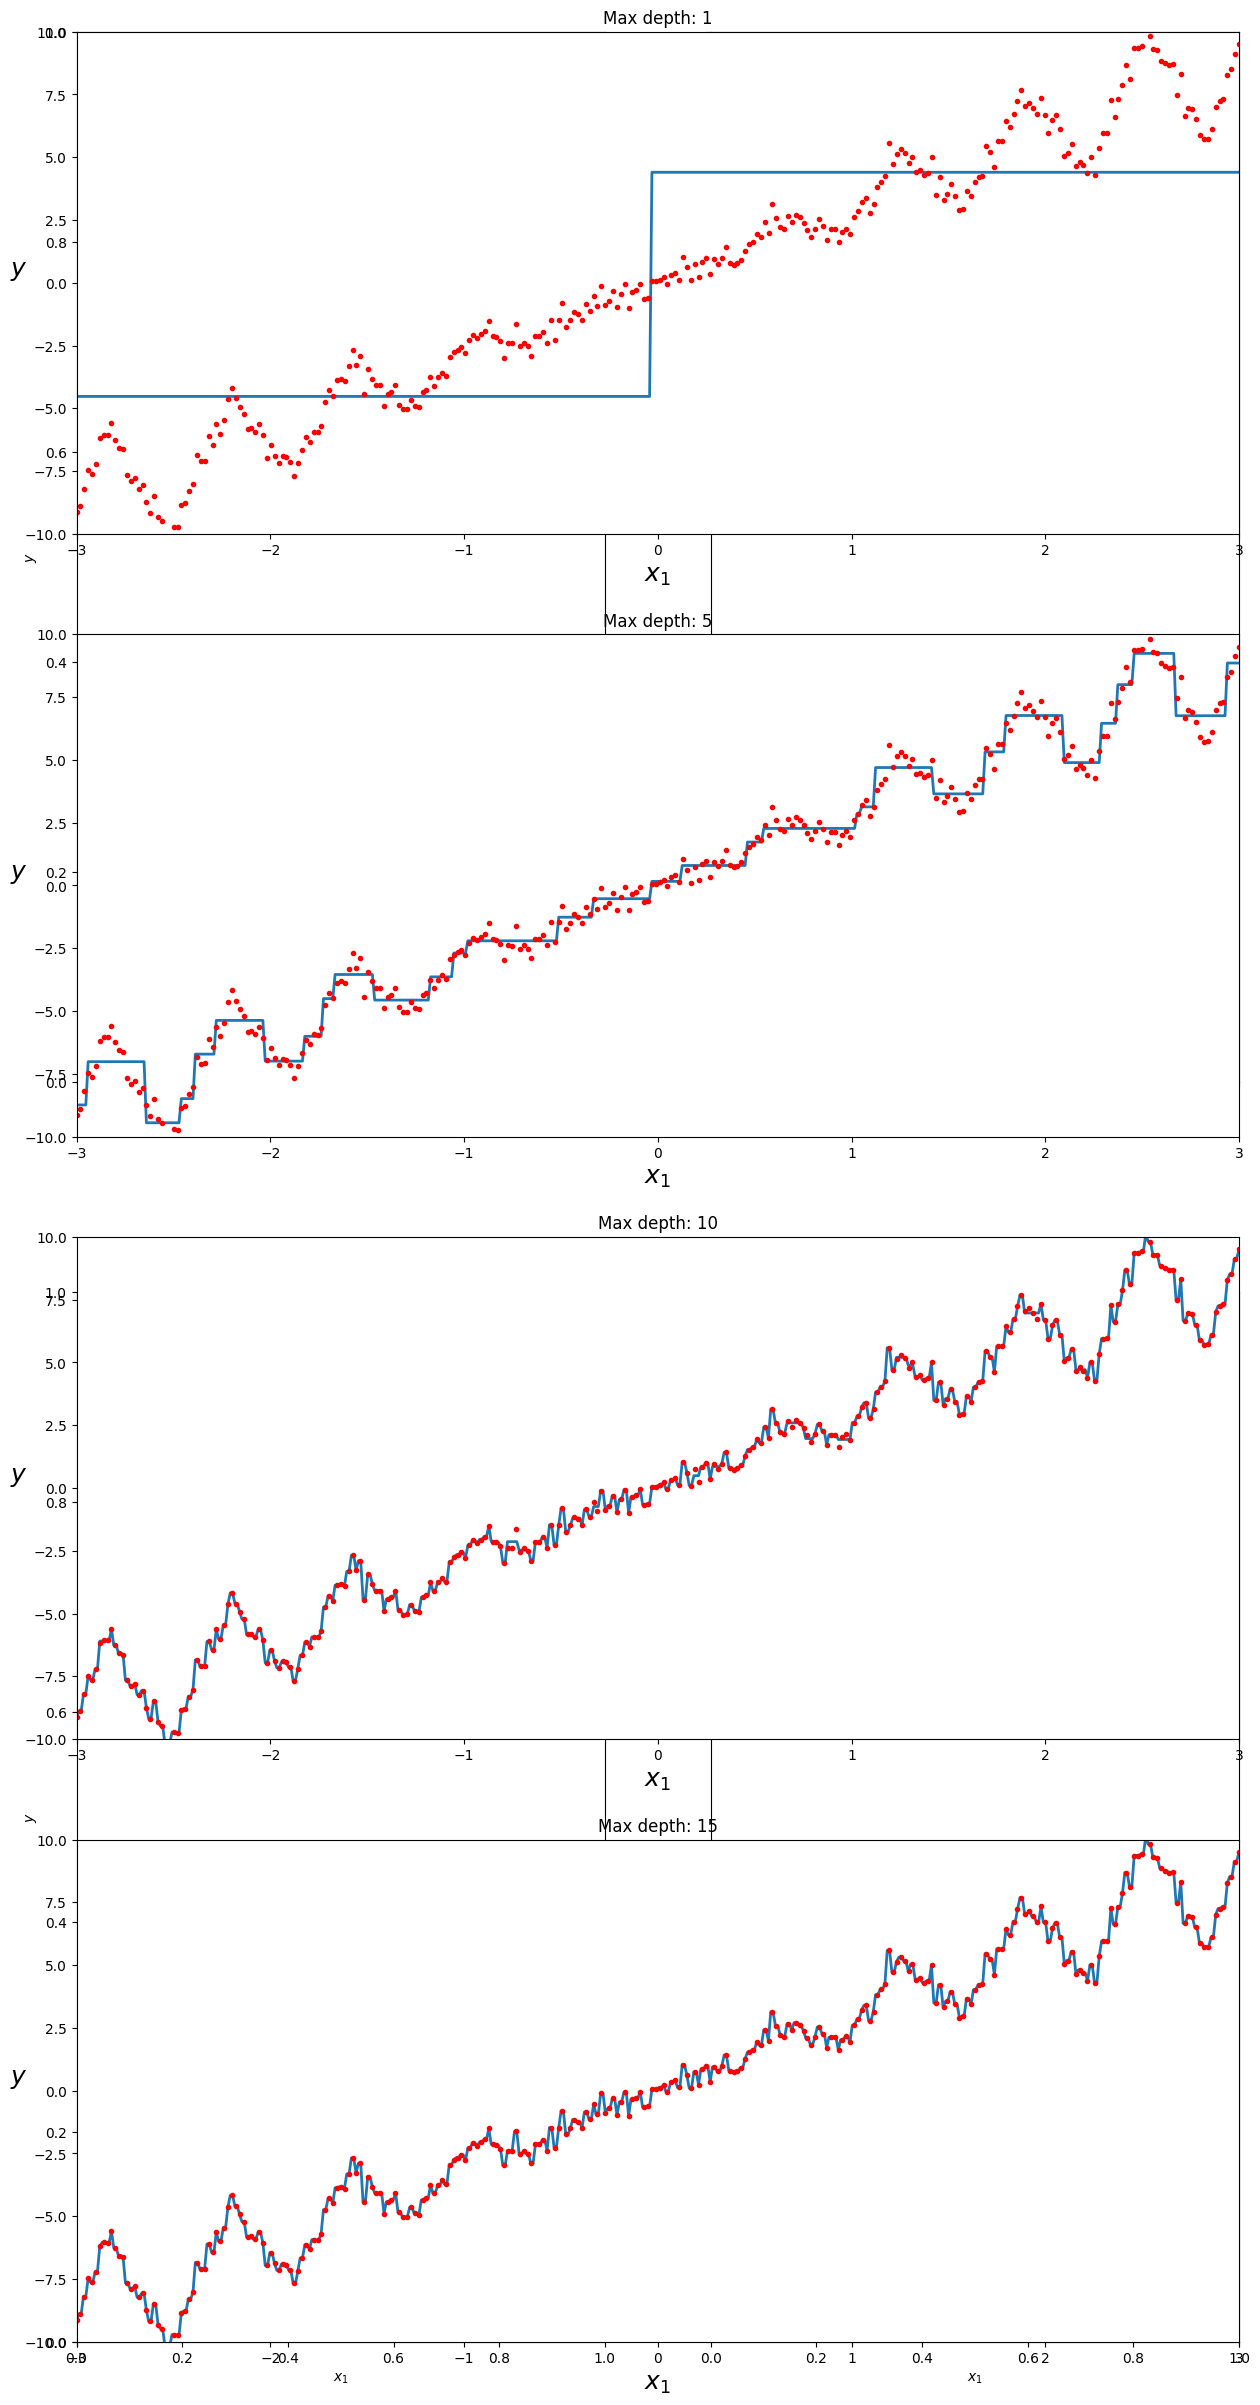

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(15, 30))
axes = axes.flat

for i, d in enumerate([1,5,10,15]):
    axes[i].set(xlabel="$x_1$", ylabel="$y$")
    axes[i].label_outer()
    model = DecisionTreeRegressor(max_depth=d).fit(X, y)
    ax = plt.subplot(410+ (i+1))
    ax.set_title(f"Max depth: {d}")
    plot_regression_predictions(model, X, y)

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [132]:
import scipy
from scipy.stats import binom 
scipy.stats.binom.pmf(51, 101, 0.5)

0.07880895074612795

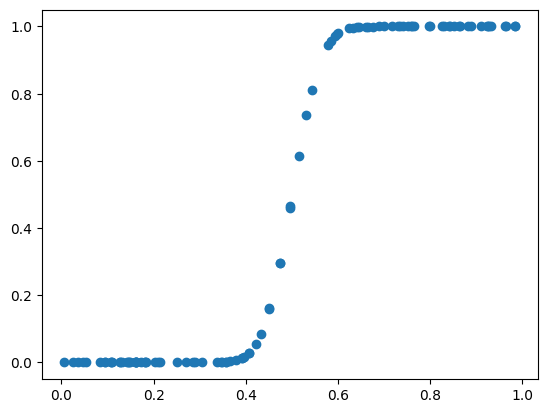

In [159]:
p_values = np.random.uniform(low=0.0, high=1.0, size=100)
mu = []
for p in p_values:
       mu.append([np.sum([scipy.stats.binom.pmf(k, n=101, p=p) for k in range(51,102)])])
plt.scatter(p_values, mu)


А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

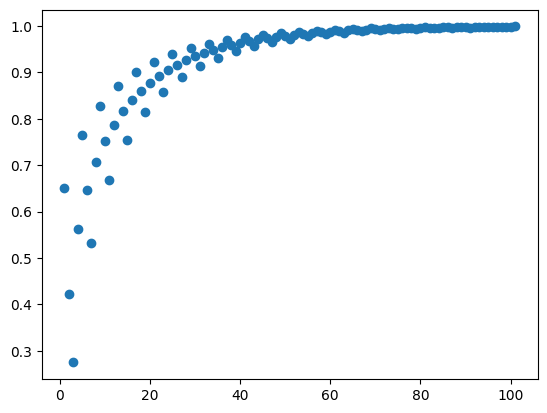

In [179]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
mu =  []
for i in range(1, 102):
   mu.append([np.sum([scipy.stats.binom.pmf(k=r, p=0.65, n=i) for r in range(int(round(i/2, 0))+1,i+1)])])
plt.scatter(nums, mu)


Опишите ваши наблюдения:

* с увеличением числа моделей (классификаторов) в ансамбле повышается вероятность правильных предсказаний 
* с повышением вероятности правильных предсказаний для каждой модели, вероятность правильных предсказаний всем ансамблем увеличивается соответвенно
* в обоих случаях наблюдается плато при приближении к наиболее высоким значениям

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [5]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state = 111):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = 111

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        self.max_features = X.shape[1]
        ids = [n for n in range(X.shape[0])]
        for i in range(0, self.n_estimators-1):
            self.random_state = np.random.seed(111 + i)
            sidx   = list(set(np.random.choice(range(X.shape[0]), X.shape[0], replace=True))) #list(set(np.random.choice(range(X.shape[0]), X.shape[0],replace=True)))
            #b_samp = X[sidx,:]
            feat_ids_by_tree = np.random.choice(X.shape[1], self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids_by_tree)
            model = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state = self.random_state)
            model.fit(X[sidx,:][:, feat_ids_by_tree], y[sidx])
            self.trees.append(model)
        
        return self

    def predict_proba(self, X):
        predictions = []
        #print(self.feat_ids_by_tree)
        for i in range(0, self.n_estimators-1):
            ids = self.feat_ids_by_tree[i]
            predictions.append(self.trees[i].predict_proba(X[:,ids]))
        return np.mean(predictions, axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [6]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

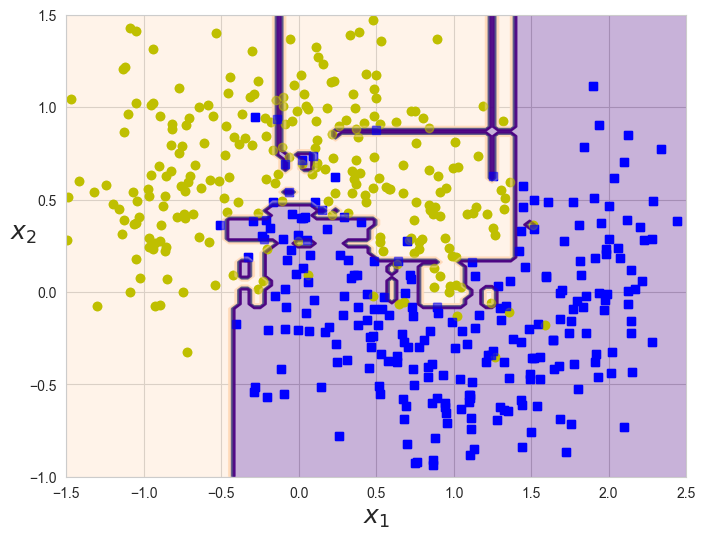

In [10]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=111)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)
plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
clf = RandomForestClassifierCustom(random_state = 111)
clf.fit(X,y)
plot_decision_boundary(clf, X, y)
plt.show()

#модель переобучена

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

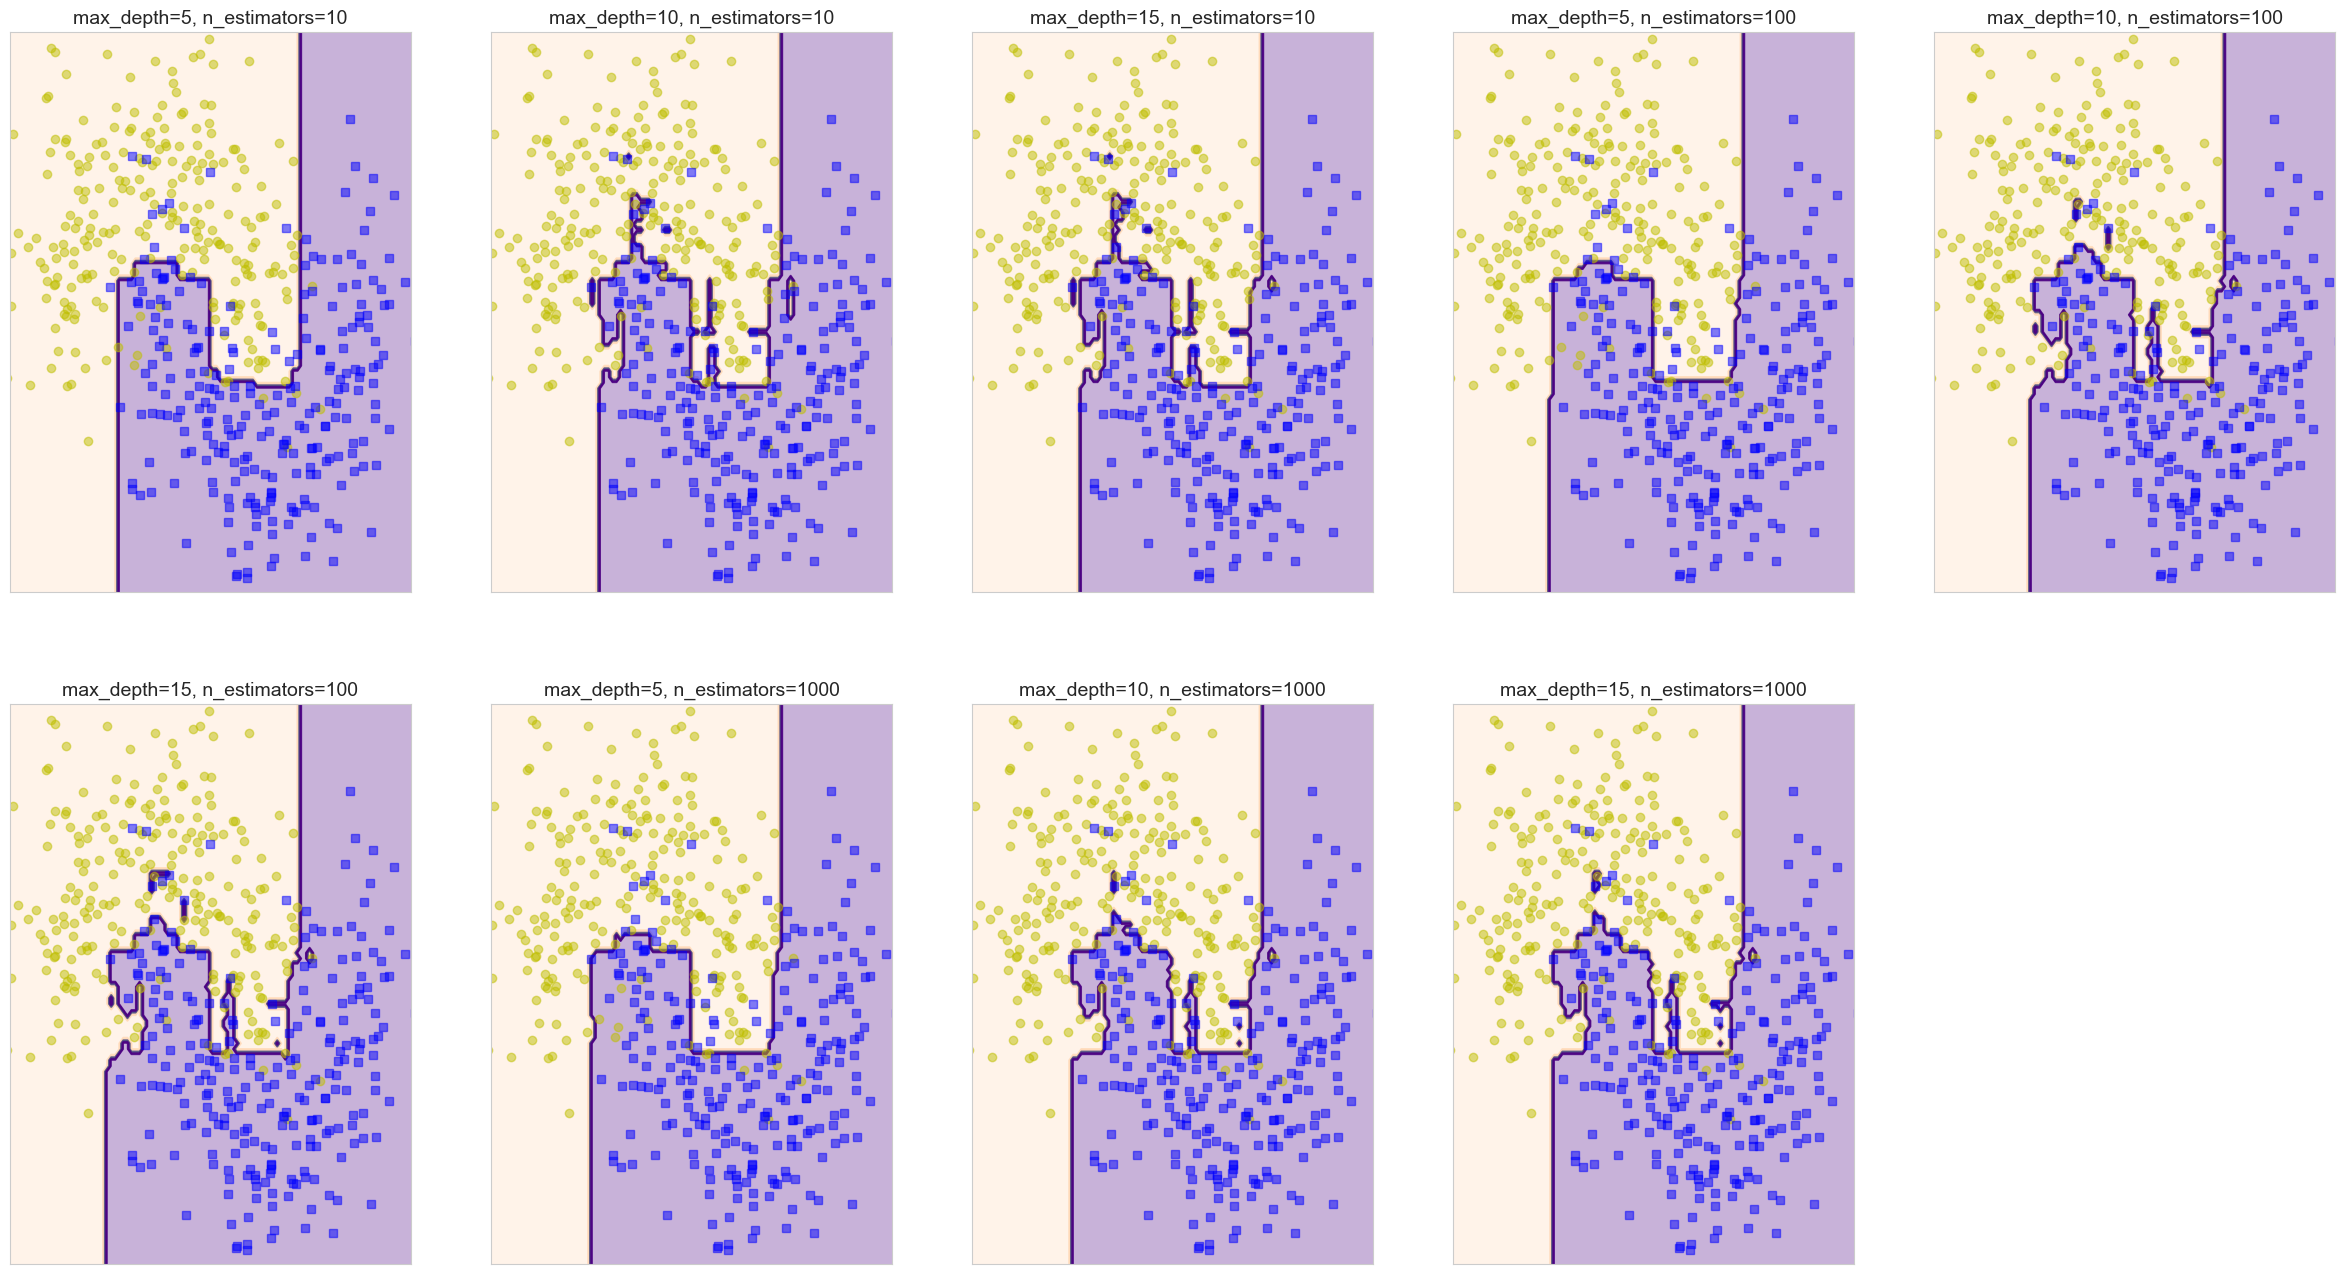

In [11]:
plt.figure(figsize=(30,16))

count = 1
for n in [10,100,1000]:
     for depth in [5,10,15]:
            plt.subplot(250+count)
            clf = RandomForestClassifierCustom(max_depth=depth, n_estimators=n) 
            clf.fit(X_train, y_train)
            plot_decision_boundary(clf, X, y)
            plt.xticks([], [])
            plt.yticks([], [])
            
            plt.title(f"max_depth={depth}, n_estimators={n}", fontsize=14)
            plt.xlabel("")
            plt.ylabel("")
            plt.xticks([], [])
            plt.yticks([], [])
            count +=1 

In [ ]:
#Судя по графикам при max_depth=5 и n_estimators > 10 достигается наиболее оптимальный bias-variance trade-off
#При глубине дерева больше 5- видно, что модель переобучается
#переход от 100 до 1000 моделей существенно не сказывается на качестве модели

In [13]:
from sklearn.metrics import average_precision_score
#Проврим, какая глубина дерева наиболее оптимальна: 5 или 10 (потому что графики были наиболее оптимальными для этих глубин)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

rf1 = RandomForestClassifierCustom(max_depth=10, n_estimators=1000).fit(X_train, y_train)

rf2 = RandomForestClassifierCustom(max_depth=5, n_estimators=1000).fit(X_train, y_train)

q = average_precision_score(y_true=y_train, y_score=rf1.predict(X_train))
print(f"RF1 Max_depth=10 Train: {q:.02}")
q = average_precision_score(y_true=y_train, y_score=rf2.predict(X_train))
print(f"RF2 Max_depth=5 Train: {q:.02}")

q = average_precision_score(y_true=y_test, y_score=rf1.predict(X_test))
print(f"RF1 Max_depth=10 Test: {q:.02}")
q = average_precision_score(y_true=y_test, y_score=rf2.predict(X_test))
print(f"RF2 Max_depth=5 Test: {q:.02}")

#Как можно видеть, при большей глубине дерева, модель на 100% правильно предсказывает тренировочную выборку, но не уступает дереву с меньшей глубиной 
#при предсказании тестовой выборки

RF1 Max_depth=10 Train: 1.0
RF2 Max_depth=5 Train: 0.93
RF1 Max_depth=10 Test: 0.86
RF2 Max_depth=5 Test: 0.86


#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [14]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [20]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

In [19]:

rfc1 = RandomForestClassifier(max_features=5)
rfc2 = RandomForestClassifier(max_features=10)
rfc3 = RandomForestClassifier(max_features=20)
rfc4 = RandomForestClassifier(max_features=30)

rfc1.fit(X_train, y_train)
rfc2.fit(X_train, y_train)
rfc3.fit(X_train, y_train)
rfc4.fit(X_train, y_train)

RandomForestClassifier(max_features=30)

In [21]:
ensemble1 = base_model_pair_correlation(rfc1, X)
ensemble2 = base_model_pair_correlation(rfc2, X)
ensemble3 = base_model_pair_correlation(rfc3, X)
ensemble4 = base_model_pair_correlation(rfc4, X)

In [22]:
corrs = pd.DataFrame({"max_features=5": ensemble1,
                       "max_features=10": ensemble2,
                       "max_features=20": ensemble3, "max_features=30": ensemble4})
corss_melt = pd.melt(corrs, var_name="Ensemble", value_name="Correlation")

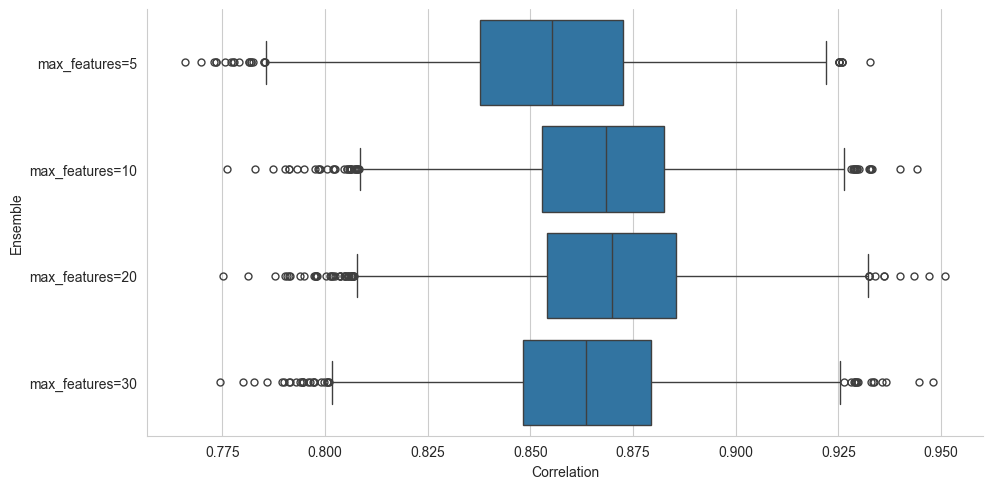

In [24]:
sns.catplot(data=corss_melt, x="Correlation", y="Ensemble", kind="box", aspect=2)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

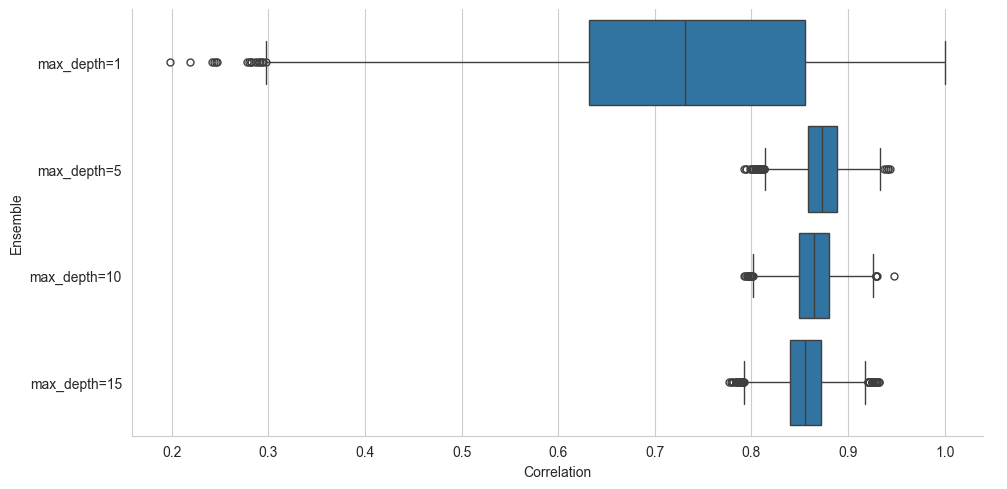

In [27]:
rfc5 = RandomForestClassifier(max_depth=1)
rfc6 = RandomForestClassifier(max_depth=5)
rfc7 = RandomForestClassifier(max_depth=10)
rfc8 = RandomForestClassifier(max_depth=15)


rfc5.fit(X_train, y_train)
rfc6.fit(X_train, y_train)
rfc7.fit(X_train, y_train)
rfc8.fit(X_train, y_train)

ensemble5 = base_model_pair_correlation(rfc5, X)
ensemble6 = base_model_pair_correlation(rfc6, X)
ensemble7 = base_model_pair_correlation(rfc7, X)
ensemble8 = base_model_pair_correlation(rfc8, X)

corrs2 = pd.DataFrame({"max_depth=1": ensemble5,
                       "max_depth=5": ensemble6,
                       "max_depth=10": ensemble7, "max_depth=15": ensemble8})
corss_melt2 = pd.melt(corrs2, var_name="Ensemble", value_name="Correlation")
sns.catplot(data=corss_melt2, x="Correlation", y="Ensemble", kind="box", aspect=2)
plt.show()

Опишите ваши наблюдения:

* При максимальном и минимальном max_features наблюдается наименьшая корреляция
* При минимальной глубине дерева (1) наблюдается слишком низкая корреляция моделей (такая модел  из-за простоты делает предсказания рандомные и неточные). При наибольшей глубине дерева (15) удается снизить по кореляцию моделей в ансамбле по сравнению с моделями, у которых средние значения глубины.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [31]:
!pip install gdown
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 1.1 MB/s eta 0:00:00a 0:00:01
/Users/mariababaeva/miniforge3/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y-
To: /Users/mariababaeva/heart.csv
100%|██████████████████████████████████████| 11.3k/11.3k [00:00<00:00, 16.8MB/s]


In [41]:
heart_dataset = pd.read_csv("heart.csv")

In [42]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [60]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

NameError: name 'catboost' is not defined

#У меня ошибка 'catboost' в юпитере, я сделала это задание в колабе
https://colab.research.google.com/drive/1H_qebJT3-GHME_AhAM3ENWdXkobsk2tw?usp=sharing

In [36]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

NameError: name 'base_models' is not defined

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [8]:

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [127]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

#base_model_pair_correlation_for_voting_clf(voting_hard, X)

#Cделала в google colab
https://colab.research.google.com/drive/1H_qebJT3-GHME_AhAM3ENWdXkobsk2tw?usp=sharing 

Я продублировала весь код здесь, чтобы вы не думали, что я дописала после дедлайна

In [ ]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

In [ ]:
model_score = {}
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, lr, nb, voting_hard, voting_soft, xgb, lgbm, xgb_rf, lgbm_rf]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    if model == voting_soft:
        model_score[str(model.__class__.__name__)+'_soft'] = scores.mean()
    else:
        model_score[str(model.__class__.__name__)] = scores.mean()
    #print(f"{model.__class__.__name__}: {scores.mean()}")
model_score

In [ ]:
model_score

In [ ]:
ensemble_1 = VotingClassifier(estimators=base_models, voting='hard')
ensemble_1.fit(X_train, y_train)

In [ ]:
corrs_1 = base_model_pair_correlation_for_voting_clf(ensemble_1, X_test)

In [ ]:
corrs_1

#Пары с наибольшей корреляцией:
#RandomForestClassifier, ExtraTreesClassifier - 0.9215651183028867
#RandomForestClassifier, CatBoostClassifier - 0.9450698035153566
#SVC, LogisticRegression -0.9521587816734959
#CatBoostClassifier, LGBMClassifier- 0.9552781313087828
#CatBoostClassifier, XGBRFClassifier- 0.9454804718176699
#LGBMClassifier, XGBClassifier - 0.970838692549758)

In [ ]:
#ансамбль без ("LGBM", lgbm),("XGB", xgb), ("SVC_RBF", svc_rbf), ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf) - так как у них высокая корреляция
base_models2 = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), 
               ("CAT", cat), ("LR", lr), ("NB", nb)]

voting_hard2 = VotingClassifier(estimators=base_models2, voting='hard')
score = cross_val_score(voting_hard2, X_train, y_train, cv=3, scoring="f1")
print(score.mean())
#у исходного ансамбля было f1_score = 0.8494440278941667
#у оптимизированного ансамбля  f1_score = 0.8505430242272348

In [ ]:
# удаление модели ("ETC", etc) позволило еще немного повысить f1_score до 0.8550197256497287
base_models3 = [("DT", dt), ("RF", rf),  ("KNN", knn),
               ("SVC_LIN", svc_lin), 
               ("CAT", cat), ("LR", lr), ("NB", nb)]

voting_hard3 = VotingClassifier(estimators=base_models3, voting='hard')
score2 = cross_val_score(voting_hard3, X_train, y_train, cv=3, scoring="f1")
print(score2.mean())
#f1_score = 0.8550197256497287

In [ ]:
#удаление модели Ransom forest позволило еще немного повысить f1_score до 0.8598720463248343
base_models4 = [("DT", dt),  ("KNN", knn),
               ("SVC_LIN", svc_lin), 
               ("CAT", cat), ("LR", lr)]

voting_hard4 = VotingClassifier(estimators=base_models4, voting='hard')
score3 = cross_val_score(voting_hard4, X_train, y_train, cv=3, scoring="f1")
print(score3.mean())
#f1_score = 0.8598720463248343

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [ ]:
#У меня ошибка 'catboost' в юпитере, я сделала это задание в колабе
https://colab.research.google.com/drive/1H_qebJT3-GHME_AhAM3ENWdXkobsk2tw?usp=sharing

In [130]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

![image](bunnies.png)

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

In [ ]:
Мне очень понравилась эта тема)